1. Import Required Libraries

In [1]:
import os
import random
import sys
import argparse


# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim


# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models
from torchvision.transforms import ToTensor, Resize, Normalize
from torch.utils.data import Dataset, DataLoader

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

#from models import Model
#from datasets import get_data_loaders
#from train import train
#from test import evaluate, load_model

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


2. Set the Hyperparameters

In [2]:
# Paths to real and fake image directories
train_real_path = r"D:\Projects\SP CUP Dataset\valid\real" # r is because of the backslash causing \p 
train_fake_path = r"D:\Projects\SP CUP Dataset\valid\fake" # to be interpreted as a special character

test_real_path = r"D:\Projects\SP CUP Dataset\Small train\real"
test_fake_path = r"D:\Projects\SP CUP Dataset\Small train\fake"

BATCH_SIZE = 32 # Batch size for training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



0 for real and 1 for fake since classes = ['real', 'fake']

The train_dataloader is created with shuffle=True to shuffle the training data at the beginning of each epoch.

The test_dataloader is created with shuffle=False to keep the order of the test data consistent.

3. Set dataset folders for training

In [3]:
# Get the image filenames
train_real_count = len(os.listdir(train_real_path))
train_fake_count = len(os.listdir(train_fake_path))

test_real_count = len(os.listdir(test_real_path))
test_fake_count = len(os.listdir(test_fake_path))

print(f"Train Real images: {train_real_count}, Train Fake images: {train_fake_count}")
print(f"Test Real images: {test_real_count}, Test Fake images: {test_fake_count}")

Train Real images: 1548, Train Fake images: 1524
Test Real images: 20, Test Fake images: 20


4. Preparing the Datasets

4.1 Training Data

In [4]:
#Define the maximum number of samples per class
MAX_SAMPLES_PER_CLASS = 40000  # Programmer-defined limit

# Get the image filenames
train_real_images = os.listdir(train_real_path)
train_fake_images = os.listdir(train_fake_path)

# Apply the limit
train_real_images = train_real_images[:min(MAX_SAMPLES_PER_CLASS, len(train_real_images))]
train_fake_images = train_fake_images[:min(MAX_SAMPLES_PER_CLASS, len(train_fake_images))]

# Combine and label the dataset
train_balanced_dataset = [(os.path.join(train_real_path, img), 0) for img in train_real_images] + \
                   [(os.path.join(train_fake_path, img), 1) for img in train_fake_images]

# Shuffle the dataset
random.shuffle(train_balanced_dataset)

# Verify the limited dataset size
print(f"Total dataset size: {len(train_balanced_dataset)} (Real: {len(train_real_images)}, Fake: {len(train_fake_images)})")


Total dataset size: 3072 (Real: 1548, Fake: 1524)


4.2 Testing Data

In [5]:
#Define the maximum number of samples per class
MAX_SAMPLES_PER_CLASS = 40000  # Programmer-defined limit

# Get the image filenames
test_real_images = os.listdir(test_real_path)
test_fake_images = os.listdir(test_fake_path)

# Apply the limit
test_real_images = test_real_images[:min(MAX_SAMPLES_PER_CLASS, len(test_real_images))]
test_fake_images = test_fake_images[:min(MAX_SAMPLES_PER_CLASS, len(test_fake_images))]

# Combine and label the dataset
test_balanced_dataset = [(os.path.join(test_real_path, img), 0) for img in test_real_images] + \
                   [(os.path.join(test_fake_path, img), 1) for img in test_fake_images]

# Shuffle the dataset
random.shuffle(test_balanced_dataset)

# Verify the limited dataset size
print(f"Total dataset size: {len(test_balanced_dataset)} (Real: {len(test_real_images)}, Fake: {len(test_fake_images)})")


Total dataset size: 40 (Real: 20, Fake: 20)


5. Visualize the dataset

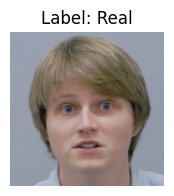

Image file name: train_real_0000070.png
Image Shape: (256, 256)


In [6]:
# Load the first image from the balanced dataset
image_path, label = train_balanced_dataset[0]
image_path, label = test_balanced_dataset[0]

# Open the image using PIL
image = Image.open(image_path)

# Display the image using matplotlib
plt.figure(figsize=(2, 2))  # Adjust the figsize to make the image smaller
plt.imshow(image)
plt.title(f"Label: {'Real' if label == 0 else 'Fake'}")
plt.xlabel(os.path.basename(image_path))  # Display the image name
plt.axis('off')  # Hide the axis
plt.show()

# Display the image file name after the image
print(f"Image file name: {os.path.basename(image_path)}")
print(f"Image Shape: {image.size}")

5.1 Plot more Images

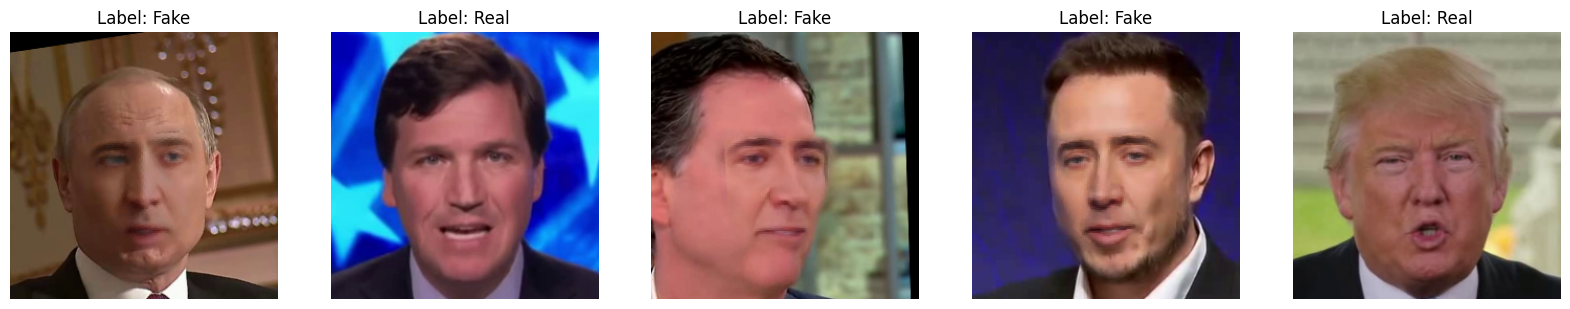

Image file name: valid_fake_0029961.png
Image file name: valid_real_0075848.png
Image file name: valid_fake_0334071.png
Image file name: valid_fake_0675829.png
Image file name: valid_real_0403025.png


In [7]:
# Set the random seed for reproducibility
random.seed(42)

# Randomly select 5 images from the balanced dataset
selected_indices = random.sample(range(len(train_balanced_dataset)), 5)
balanced_dataset5_1 = train_balanced_dataset
#selected_indices = random.sample(range(len(test_balanced_dataset)), 5)
# balanced_dataset5_1 = test_balanced_dataset


# Display 5 images in a row
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

for i, idx in enumerate(selected_indices):
    image_path, label = balanced_dataset5_1[idx]
    image = Image.open(image_path)
    
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {'Real' if label == 0 else 'Fake'}")
    axes[i].set_xlabel(os.path.basename(image_path))  # Display the image name
    axes[i].axis('off')  # Hide the axis

plt.show()

# Display the image file names after the images
for idx in selected_indices:
    image_path, _ = balanced_dataset5_1[idx]
    print(f"Image file name: {os.path.basename(image_path)}")
    

6. Getting the datasets ( Setup training data)

In [8]:
# Define the dataset class
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        super().__init__()  # Call the parent class's init method
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label
    

# Define transforms
transform = transforms.Compose([
    Resize((128, 128)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#Define the classes
classes = ['real', 'fake']

#Create the dataset
train_data = ImageDataset(train_balanced_dataset, 
                          transform=transform)

#Create the dataset
test_data = ImageDataset(test_balanced_dataset, 
                        transform=transform)

# Example: Print the class name of a label
for image, label in test_data:
    class_name = classes[label]
    #print(f"Image label: {label}, Class name: {class_name}")
    #break  # Just print the first one for demonstration


7. Visualize train_data and labels

In [9]:
print(len(train_data)) 
print(len(test_data))

image, label = train_data[700] # Label is 1
#image, label = train_data[1600] # Label is 0
print(image.shape, label)

# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {[label]}")

3072
40
torch.Size([3, 128, 128]) 1
Image shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image label: [1]


7.1 Checking Labels of more data

In [10]:
# Set the random seed for reproducibility
random.seed(42)
#dataset = train_data
dataset = test_data


# Select 50 random images
selected_indices = random.sample(range(len(dataset)), 10)

# Print the shape of images and labels of 50 random images
for idx in selected_indices:
    image, label = dataset[idx]
    image_path, _ = dataset.data[idx]
    print(f"Image file name: {os.path.basename(image_path)}")
    print(f"Image shape: {image.shape}, Label: {label}")

Image file name: train_fake_0000029.png
Image shape: torch.Size([3, 128, 128]), Label: 1
Image file name: train_real_0000421.png
Image shape: torch.Size([3, 128, 128]), Label: 0
Image file name: train_real_0000074.png
Image shape: torch.Size([3, 128, 128]), Label: 0
Image file name: train_fake_0000105.png
Image shape: torch.Size([3, 128, 128]), Label: 1
Image file name: train_real_0000259.png
Image shape: torch.Size([3, 128, 128]), Label: 0
Image file name: train_fake_0000019.png
Image shape: torch.Size([3, 128, 128]), Label: 1
Image file name: train_fake_0000098.png
Image shape: torch.Size([3, 128, 128]), Label: 1
Image file name: train_fake_0000118.png
Image shape: torch.Size([3, 128, 128]), Label: 1
Image file name: train_fake_0000062.png
Image shape: torch.Size([3, 128, 128]), Label: 1
Image file name: train_real_0000150.png
Image shape: torch.Size([3, 128, 128]), Label: 0


7.2 Visualize our data

Image shape: torch.Size([3, 128, 128])


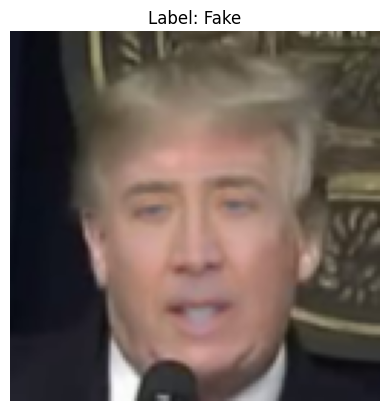

Image file name: train_real_0000150.png


In [11]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
# Unnormalize the image
# We have to use the relevant mean and std values for this
plt.imshow(image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize the image
plt.title(f"Label: {'Real' if label == 0 else 'Fake'}")
plt.axis('off')
plt.show()
image_path, _ = dataset.data[idx]
print(f"Image file name: {os.path.basename(image_path)}")

7.3 Visualize more data

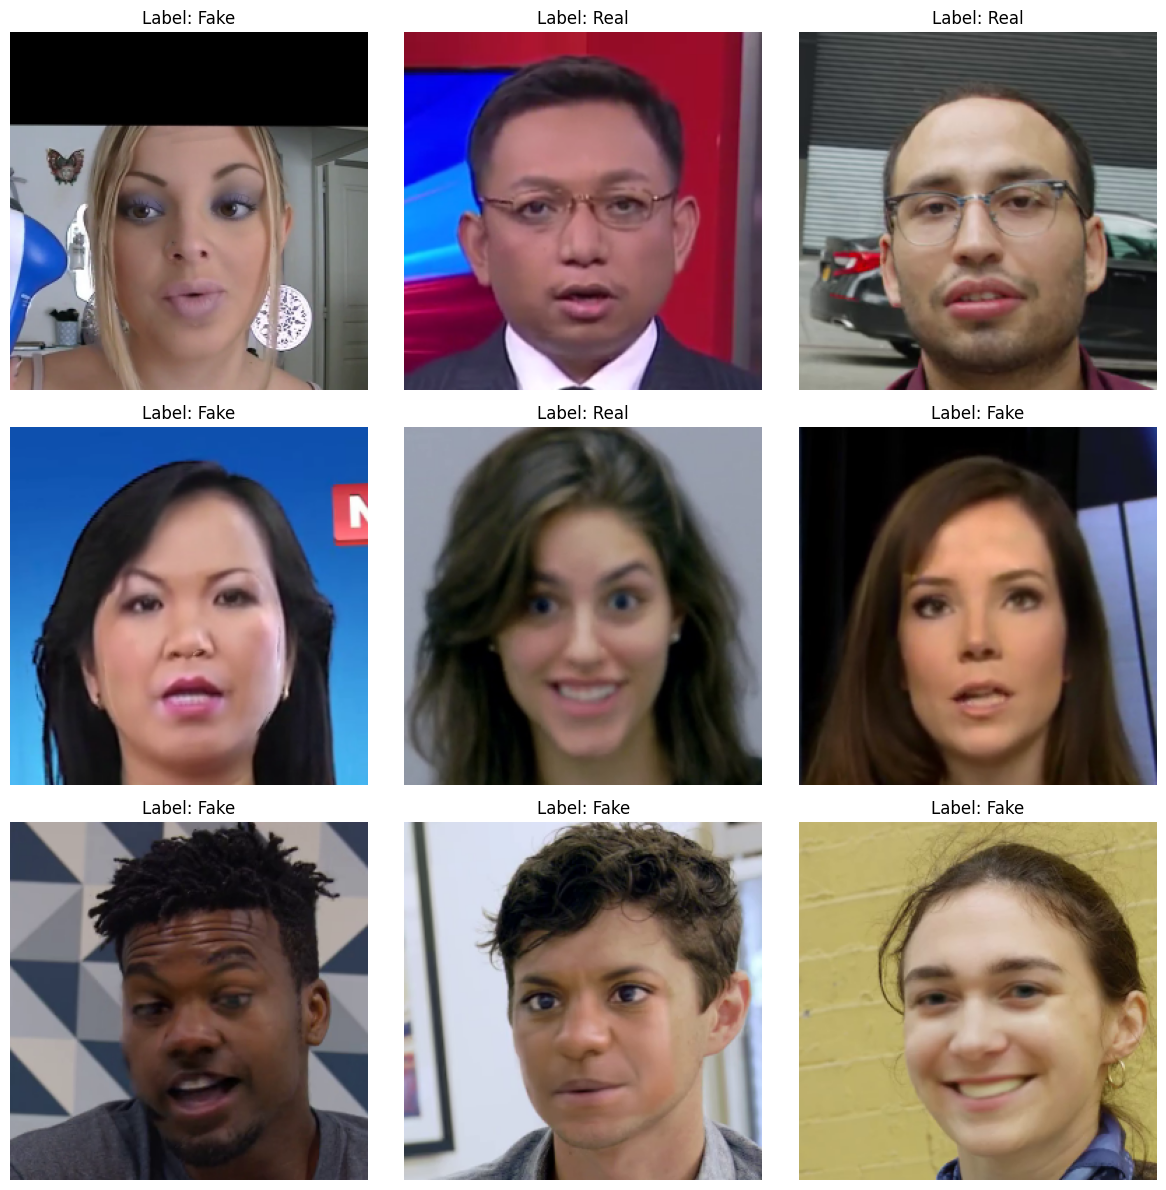

Image file name: train_fake_0000029.png
Image file name: train_real_0000421.png
Image file name: train_real_0000074.png
Image file name: train_fake_0000105.png
Image file name: train_real_0000259.png
Image file name: train_fake_0000019.png
Image file name: train_fake_0000098.png
Image file name: train_fake_0000118.png
Image file name: train_fake_0000062.png


In [12]:
# Set the random seed for reproducibility
random.seed(42)
balanced_dataset7_3 = train_balanced_dataset
balanced_dataset7_3 = test_balanced_dataset

# Randomly select 9 images from the balanced dataset
selected_indices = random.sample(range(len(balanced_dataset7_3)), 9)

# Display 9 images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3 rows, 3 columns

for i, idx in enumerate(selected_indices):
    image_path, label = balanced_dataset7_3[idx]
    image = Image.open(image_path)
    
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.set_title(f"Label: {'Real' if label == 0 else 'Fake'}")
    ax.set_xlabel(os.path.basename(image_path))  # Display the image name
    ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

# Display the image file names after the images
for idx in selected_indices:
    image_path, _ = balanced_dataset7_3[idx]
    print(f"Image file name: {os.path.basename(image_path)}")

In [13]:
train_data

In [14]:
#Calculate the mean and std of the dataset

8. Prepare DataLoader

In [15]:
# Create the DataLoader
train_dataloader = DataLoader(train_data, 
                        batch_size=BATCH_SIZE,
                        shuffle=True)

test_dataloader = DataLoader(test_data, 
                        batch_size=BATCH_SIZE,
                        shuffle=False)

# Example: Iterate through the DataLoader
for images, labels in test_dataloader:
    print(images.shape, labels.shape)
    break

print(images[0].shape)
train_dataloader, test_dataloader

torch.Size([32, 3, 128, 128]) torch.Size([32])
torch.Size([3, 128, 128])


(<torch.utils.data.dataloader.DataLoader at 0x22e902ba6f0>,
 <torch.utils.data.dataloader.DataLoader at 0x22e8ffdae70>)

8.1 Check what we have created

In [16]:
# Let's check out what what we've created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}... = {BATCH_SIZE*len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}... = {BATCH_SIZE*len(test_dataloader)}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000022E902BA6F0>, <torch.utils.data.dataloader.DataLoader object at 0x0000022E8FFDAE70>)
Length of train_dataloader: 96 batches of 32... = 3072
Length of test_dataloader: 2 batches of 32... = 64


8.2 What's inside the dataloaders

In [17]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

9. Building a baseline Model

In [18]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 16384]) -> [color_channels, height*width]


9.1 Modelv0

In [19]:
from torch import nn
class DeepFakeDetectV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [20]:
len(classes)

2

9.2 Setup the model for the first time

In [21]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = DeepFakeDetectV0(
    input_shape=3*128*128, # this is 128*128 (height*width)
    hidden_units=10, # how mnay units in the hidden layer
    output_shape=1 # one for every class
).to("cpu")
model_0.to(device)

# Check the device of the model
model_0_device = next(model_0.parameters()).device
print(f"Model is on device: {model_0_device}")
model_0

Model is on device: cuda:0


DeepFakeDetectV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=49152, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

9.3 Send a random value through to check the output

In [22]:
dummy_x = torch.rand([1, 3, 128, 128]).to(device)
model_0(dummy_x)

tensor([[-0.0132]], device='cuda:0', grad_fn=<AddmmBackward0>)

9.4 Check the State Dictionary of the model

In [23]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0034,  0.0037, -0.0011,  ..., -0.0014, -0.0021, -0.0008],
                      [ 0.0006,  0.0002,  0.0009,  ..., -0.0025, -0.0020, -0.0038],
                      [ 0.0021, -0.0007, -0.0014,  ...,  0.0018, -0.0030, -0.0042],
                      ...,
                      [-0.0002,  0.0023, -0.0012,  ..., -0.0017,  0.0010, -0.0024],
                      [-0.0023, -0.0022, -0.0015,  ..., -0.0014, -0.0031,  0.0001],
                      [-0.0005,  0.0032,  0.0041,  ...,  0.0043, -0.0004, -0.0040]],
                     device='cuda:0')),
             ('layer_stack.1.bias',
              tensor([ 0.0024,  0.0020,  0.0018,  0.0044, -0.0021, -0.0030, -0.0043, -0.0016,
                      -0.0002, -0.0044], device='cuda:0')),
             ('layer_stack.2.weight',
              tensor([[ 0.2576, -0.1573, -0.0215,  0.1024,  0.0279,  0.1325, -0.0274,  0.0770,
                       -0.1803, -0.1312]], device='cuda:0')),
     

10. Setup Loss, Optimizer and evaluation metrics

10.1 Setup Loss and Optimizer

In [24]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

10.2 Function to time our experiments

In [25]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


4.0299999454873614e-05

In [26]:
# Iterate through the test_dataloader and print the first 5 values
for i, (images, labels) in enumerate(test_dataloader):
    if i < 1:
        print(f"Batch {i+1}:")
        print(f"Images: {images}")
        print(f"Labels: {labels}")
    else:
        break

Batch 1:
Images: tensor([[[[ 0.2000,  0.2000,  0.2000,  ...,  0.1922,  0.1922,  0.1922],
          [ 0.2000,  0.2000,  0.2000,  ...,  0.1922,  0.1922,  0.1922],
          [ 0.2000,  0.2000,  0.2000,  ...,  0.1922,  0.1922,  0.1922],
          ...,
          [ 0.1451,  0.1451,  0.1451,  ...,  0.3176,  0.3098,  0.3412],
          [ 0.1451,  0.1451,  0.1451,  ...,  0.3255,  0.3412,  0.3490],
          [ 0.1451,  0.1451,  0.1451,  ...,  0.2863,  0.3333,  0.3412]],

         [[ 0.2627,  0.2627,  0.2627,  ...,  0.2392,  0.2392,  0.2392],
          [ 0.2627,  0.2627,  0.2627,  ...,  0.2392,  0.2392,  0.2392],
          [ 0.2627,  0.2627,  0.2627,  ...,  0.2392,  0.2392,  0.2392],
          ...,
          [ 0.2157,  0.2157,  0.2157,  ...,  0.3961,  0.3961,  0.4275],
          [ 0.2157,  0.2157,  0.2157,  ...,  0.3961,  0.4118,  0.4353],
          [ 0.2157,  0.2157,  0.2157,  ...,  0.3647,  0.4039,  0.4118]],

         [[ 0.3882,  0.3882,  0.3882,  ...,  0.3725,  0.3725,  0.3725],
          [ 0

In [27]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  for X_test, y_test in test_dataloader:
    X_test, y_test = X_test.to(device), y_test.to(device)  # Move tensors to the same device as the model
    # 1. Forward pass
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1429],
        [-0.1723],
        [-0.1906],
        [-0.1726],
        [-0.0045]], device='cuda:0')

In [28]:
y_test[:5]

tensor([0, 1, 1, 0, 1], device='cuda:0')

In [29]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4643],
        [0.4570],
        [0.4525],
        [0.4570],
        [0.4989]], device='cuda:0')

In [30]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (model_0 -> logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
#y_preds.squeeze()

RuntimeError: Inference tensors cannot be saved for backward. To work around you can make a clone to get a normal tensor and use it in autograd.

11. Creating a Training loop and training the model

In [26]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 2

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X.to(device))

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()

    # Print out what's happening
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0
------


ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 1]))

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Define accuracy function
def accuracy_fn(y_true, y_pred):
    correct = (y_true == y_pred).sum().item()
    return correct / len(y_true)

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 2

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X).squeeze()

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y.float())
    train_loss += loss # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()

    # Print out what's happening
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test).squeeze()

      # 2. Calculate loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test.float())

      # 3. Calculate accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.round())

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))